# Transfer Learnining in tensorflow
Transfer learning is Leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benifits:

1. can leverage an existing neural network architecture proven to work on problems 
2. Can leverage a working newural network architecture which has already learned patterns on similar data 

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-08 06:25:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  51.3MB/s    in 3.1s    

2022-02-08 06:25:15 (51.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os
for dirpath, dirnames, filenames, in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 10 directori

## Create data loader (preparing the data)

We'll use the ImageDataGenerator class to load in our images in batches

In [4]:
# Setup data inputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir =  "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/225)
test_datagen = ImageDataGenerator(rescale=1/225)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(
                                train_dir,
                                target_size=IMAGE_SHAPE,
                                batch_size=BATCH_SIZE,
                                class_mode="categorical")
print("Testing images")
test_data = test_datagen.flow_from_directory(
                               test_dir,
                               target_size=IMAGE_SHAPE,
                               batch_size=BATCH_SIZE,
                               class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are ectra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

*  Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback 
#(functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback( dir_name, experiment_name ):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
  

# Creating models using TensorFlow Hub

In the past we have used TensorFlow to create our own models layer by layer from scratch.

Now we are going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub 

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the the following model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

# Creating ResNet TensorFlow Hub Feature Extraction Model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220208-062533
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 2.0770 - accuracy: 0.3253 - val_loss: 1.2441 - val_accuracy: 0.5884
Epoch 2/5
24/24 [==============================] - 22s 957ms/step - loss: 0.9826 - accuracy: 0.7067 - val_loss: 0.8843 - val_accuracy: 0.7140
Epoch 3/5
24/24 [==============================] - 23s 973ms/step - loss: 0.6798 - accuracy: 0.8067 - val_loss: 0.7755 - val_accuracy: 0.7448
Epoch 4/5
24/24 [==============================] - 22s 950ms/step - loss: 0.5180 - accuracy: 0.8453 - val_loss: 0.7432 - val_accuracy: 0.7524
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.4116 - accuracy: 0.8987 - val_loss: 0.7120 - val_accuracy: 0.7532


In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Wow! 
That is incridable. Our transfer learning feature extractor model out preformed All of the previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the training example

## Plot loss curves


In [12]:
# Let's create the loss curve 
# plot validation and training curves 

def plot_loss_curves(history):
  import matplotlib.pyplot as plt
  """
  Return seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  # how many epochs did we ran for?
  epochs = range(len(history.history["loss"])) 

  # plot loss
#  plt.subplot(2,2,1)
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()


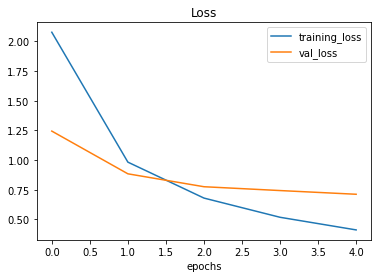

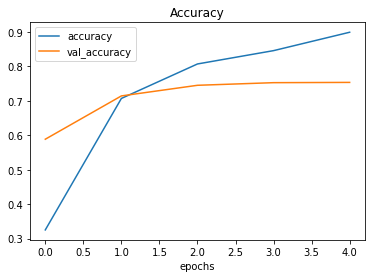

In [13]:
plot_loss_curves(resnet_history)

Creating and testing EfficientNetB0 TensorFlow Hub Extraction model

In [25]:
# Crearte EfficientNetB0 feature extractor model 
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"]
                           )
# Fir efficientNet Model to 1-% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnet")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet/20220208-071335
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.9077 - accuracy: 0.4027 - val_loss: 1.3651 - val_accuracy: 0.7040
Epoch 2/5
24/24 [==============================] - 19s 815ms/step - loss: 1.1287 - accuracy: 0.7453 - val_loss: 0.9150 - val_accuracy: 0.8048
Epoch 3/5
24/24 [==============================] - 19s 819ms/step - loss: 0.8035 - accuracy: 0.8240 - val_loss: 0.7396 - val_accuracy: 0.8308
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6460 - accuracy: 0.8560 - val_loss: 0.6452 - val_accuracy: 0.8444
Epoch 5/5
24/24 [==============================] - 19s 810ms/step - loss: 0.5483 - accuracy: 0.8747 - val_loss: 0.5887 - val_accuracy: 0.8520


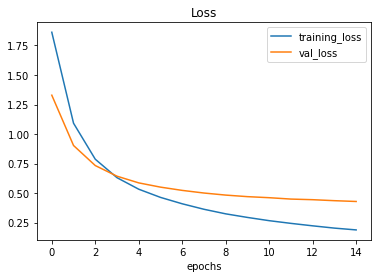

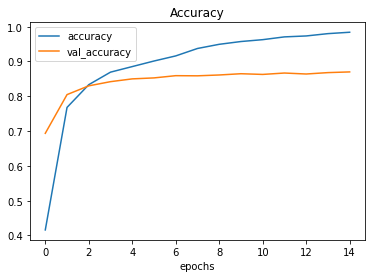

In [24]:
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [26]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=1hkL1ZOiNd4mvZMkl0psgZSvdH3rzF&prompt=consent&access_type=off

TensorBoard exprements uploaded
click on the link 
https://tensorboard.dev/experiment/E4L6qhqQTBOgDAAMMMAGxg/#scalars

In [33]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turn it into a tensor and reshape it to
  (img_shape, colur_channels).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255
  return img

In [28]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [35]:
def pred_and_plot(model, filename, class_names=class_names):
  import matplotlib.pyplot as plt

  """
  Import an image located at filename, make a prediction with model
  and plots the image with the predicted class as the title
  """
  # Import the target image and preprocess it 
  img = load_and_prep_image(filename)

  # make a prediction & Get the predicted class
  pred = model.predict(tf.expand_dims(img, axis=0))
 
  # Add in logic for multi-class
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

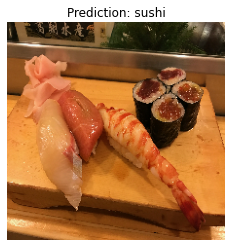

In [36]:
# Make a prediction using model_10
pred_and_plot(model=efficientnet_model,
              filename="03-sushi.jpeg",
              class_names=class_names)

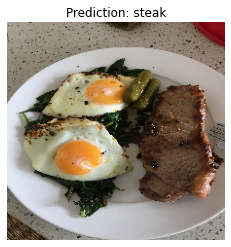

In [37]:
# Make a prediction using model_10
pred_and_plot(model=efficientnet_model,
              filename="03-steak.jpeg",
              class_names=class_names)

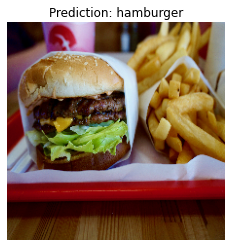

In [38]:
# Make a prediction using model_10
pred_and_plot(model=efficientnet_model,
              filename="03-hamburger.jpeg",
              class_names=class_names)

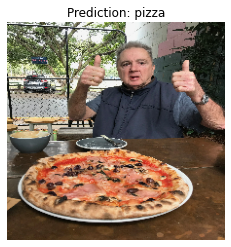

In [39]:
# Make a prediction using model_10
pred_and_plot(model=efficientnet_model,
              filename="03-pizza-dad.jpeg",
              class_names=class_names)

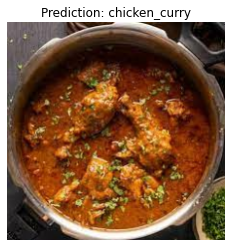

In [41]:
pred_and_plot(model=efficientnet_model,
              filename="a.jpg",
              class_names=class_names)

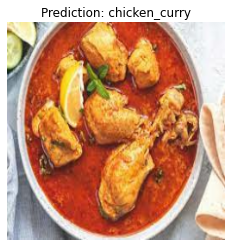

In [42]:
pred_and_plot(model=efficientnet_model,
              filename="b.jpg",
              class_names=class_names)

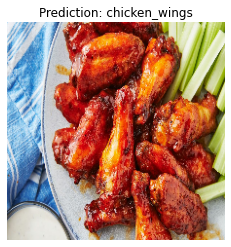

In [43]:
pred_and_plot(model=efficientnet_model,
              filename="c.jpg",
              class_names=class_names)

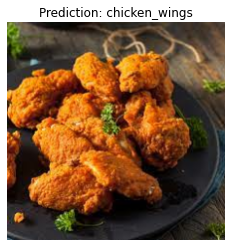

In [44]:
pred_and_plot(model=efficientnet_model,
              filename="d.jpg",
              class_names=class_names)

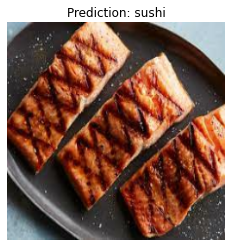

In [45]:
pred_and_plot(model=efficientnet_model,
              filename="e.jpg",
              class_names=class_names)

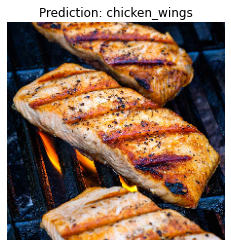

In [46]:
pred_and_plot(model=efficientnet_model,
              filename="f.jpg",
              class_names=class_names)

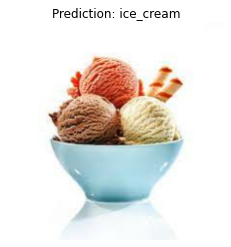

In [47]:
pred_and_plot(model=efficientnet_model,
              filename="fdh.jpg",
              class_names=class_names)

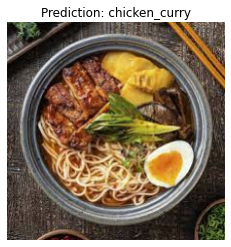

In [48]:
pred_and_plot(model=efficientnet_model,
              filename="gbd.jpg",
              class_names=class_names)

In [14]:
tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=0, 
    write_graph=True,
    write_images=False, 
    write_steps_per_second=False, 
    update_freq='epoch',
    profile_batch=0, 
    embeddings_freq=0, 
    embeddings_metadata=None, 
    **kwargs
)

NameError: ignored

In [ ]:
flow_from_directory(
                                      directory,
                                      target_size=(256, 256),
    color_mode='rgb',
    classes=None,
                                       class_mode='categorical', 
                                       batch_size=32, 
                                       shuffle=True, 
    seed=None,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)

In [ ]:
hub.KerasLayer
(
handle, 
                             trainable=False, 
arguments=None, 
_sentinel=None, 
tags=None, 
signature=None, 
signature_outputs_as_dict=None, 
output_key=None, 
output_shape=None, 
load_options=None, 
**kwargs) 

In [ ]:
  !pip install --upgrade tensorflow_hub

  import tensorflow_hub as hub

  model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
  embeddings = model(["The rain in Spain.", "falls",
                      "mainly", "In the plain!"])

  print(embeddings.shape)  #(4,128)

In [ ]:
tf.keras.callbacks.TensorBoard(
    log_dir='logs', 
    histogram_freq=0, 
    write_graph=True,
    write_images=False, 
    write_steps_per_second=False, 
    update_freq='epoch',
    profile_batch=0, 
    embeddings_freq=0, 
    embeddings_metadata=None, 
    **kwargs
)

In [ ]:
Conv2D
(
filters, 
kernel_size,
strides=(1, 1),
padding='valid',
data_format=None,
dilation_rate=(1, 1),
groups=1,
activation=None,
use_bias=True,
kernel_initializer='glorot_uniform',
bias_initializer='zeros',
kernel_regularizer=None,
bias_regularizer=None,
activity_regularizer=None,
kernel_constraint=None,
bias_constraint=None,
**kwargs
)

In [ ]:
fit(
    x=None, y=None, 
    batch_size=None, 
                                  epochs=1, 
    verbose='auto',
    callbacks=None, 
    validation_split=0.0, 
                                 validation_data=None, 
    shuffle=True,
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0, 
                                 steps_per_epoch=None,
                                 validation_steps=None, 
    validation_batch_size=None, 
    validation_freq=1,
    max_queue_size=10, 
    workers=1, 
    use_multiprocessing=False
)

In [ ]:
MaxPool2D
(
pool_size=(2, 2),
strides=None,
padding='valid',
data_format=None,
**kwargs
) 

In [ ]:
compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.FalseNegatives()])

In [ ]:
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

In [ ]:
ImageDataGenerator
(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
zca_epsilon=0.000001,
                                         rotation_range=0, 
                                         width_shift_range=0, 
                                         height_shift_range=0, 
brightness_range=None, 
                                         shear_range=0, 
                                         zoom_range=0, 
channel_shift_range=0, 
fill_mode='nearest',
cval=0, 
                                         horizontal_flip=False,
vertical_flip=False, 
                                         rescale=None, 
preprocessing_function=None, 
data_format=None,
validation_split=0, 
dtype=None
 ) 